In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)


In [2]:
image_dir = 'C:/Users/s4597578/Downloads/keras_png_slices_data/Dataset/keras_png_slices_train/image'

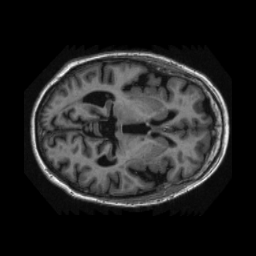

In [3]:
image_dir_1 = 'C:/Users/s4597578/Downloads/keras_png_slices_data/Dataset/keras_png_slices_train/image/case_001_slice_0.nii.png'
image = tf.keras.preprocessing.image.load_img(image_dir_1,color_mode="grayscale", target_size=None)
image